In [11]:
import pandas as pd
import pwlf
import numpy as np 
import matplotlib.pyplot as plt

In [12]:
outflow_df  = pd.read_parquet("../data/static_models/outflow_miso.par")

pump1_power_df = pd.read_parquet("../data/static_models/pump1_power_siso.par")
#pump4_power_df = pd.read_parquet("./data/static_models/pump4_power_siso.par")
#pump3_power_df = pd.read_parquet("./data/static_models/pump3_power_siso.par")

In [13]:
outflow_df = outflow_df.set_index("time")
pump1_power_df = pump1_power_df.set_index("time")

In [14]:
pump1_df = outflow_df.join(pump1_power_df["pump1_power"])

In [15]:
pump1_df['outflow_p1'] = pump1_df.apply(lambda row: row['outflow'] if row['pump1_speed'] > 0 else 0, axis=1)
#outflow_df['outflow_p3'] = outflow_df.apply(lambda row: row['outflow'] if row['pump3_speed'] > 0 else 0, axis=1)
#outflow_df['outflow_p1'] = outflow_df.apply(lambda row: row['outflow'] if row['pump1_speed'] > 0 else 0, axis=1)

In [16]:
pump1_df = pump1_df[pump1_df['outflow_p1'] > 0 ]

In [19]:
pump1_df = pump1_df[pump1_df['outflow_p1'] > 0 ].reset_index(drop=True)

In [23]:
from tqdm import tqdm

In [24]:
pump1_df['outflow_p4_hat'] = pd.NA

# Loop to iteratively compute future flow rates
for i in tqdm(range(1, len(outflow_df))):
    # Previous speed and flow values
    prev_speed = pump1_df.loc[i - 1, 'pump1_speed']
    prev_flow = pump1_df.loc[i - 1, 'outflow_p1']

    # Current speed to compute future flow rate
    current_speed = pump1_df.loc[i, 'pump1_speed']

    # Calculate future flow rate using affinity law
    future_flow = (current_speed / prev_speed) * prev_flow

    # Store the calculated future flow in the DataFrame
    pump1_df.loc[i, 'outflow_p1_hat'] = future_flow

 45%|████▌     | 6832226/15109617 [10:04<12:12, 11297.38it/s]


KeyError: 6832227

In [41]:
pump1_df

,level,outflow,pump1_speed,pump4_speed,pump3_speed,pump1_power,outflow_p1,outflow_p4_hat,outflow_p1_hat
0,153.0,2.0,40.0,268.0,0.0,27.900000,2.0,<NA>,NaN
1,153.0,3.0,85.0,235.0,0.0,27.799999,3.0,<NA>,4.250000
2,153.0,6.0,130.0,213.0,0.0,26.600000,6.0,<NA>,4.588235
3,153.0,5.0,174.0,190.0,0.0,25.400000,5.0,<NA>,8.030769
4,153.0,4.0,242.0,168.0,0.0,26.299999,4.0,<NA>,6.954023
...,...,...,...,...,...,...,...,...,...
6832222,176.0,751.0,1020.0,0.0,1020.0,47.529999,751.0,<NA>,751.000000
6832223,176.0,730.0,1020.0,0.0,1020.0,46.919998,730.0,<NA>,751.000000
6832224,176.0,720.0,1020.0,0.0,1020.0,49.200001,720.0,<NA>,730.000000
6832225,176.0,717.0,1020.0,0.0,1020.0,47.230000,717.0,<NA>,720.000000


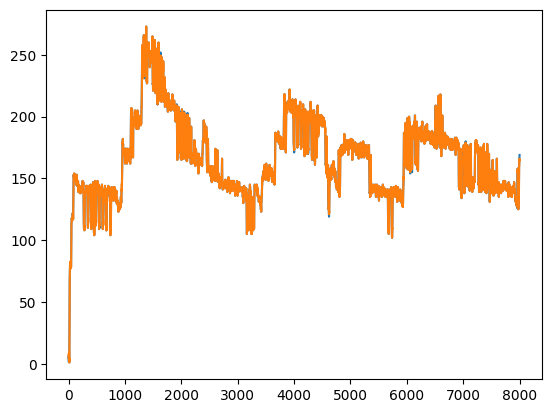

In [40]:
plt.plot(pump1_df["outflow_p1"][:8000].dropna())
plt.plot(pump1_df["outflow_p1_hat"][:8000].dropna())

#plt.plot(pump1_df["pump1_speed"][:8000].dropna())

In [42]:
import numpy as np

def simulate_arx(A_power, B_power, C_power, speed, outflow):
    """
    Simulate the ARX model for given speed and outflow data.

    Parameters:
    A_power (list of lists): The A coefficient matrix for ARX.
    B_power (list of lists): The B coefficient matrix for ARX.
    C_power (list of lists): The C coefficient matrix for ARX.
    speed (numpy.ndarray): Column vector of speed data.
    outflow (numpy.ndarray): Column vector of outflow data.

    Returns:
    numpy.ndarray: Simulated energy output values.
    """
    # Ensure inputs are numpy arrays
    A_power = np.array(A_power)
    B_power = np.array(B_power)
    C_power = np.array(C_power)
    speed = np.array(speed).flatten()
    outflow = np.array(outflow).flatten()

    # Length of data
    n_data = len(speed)

    # Initial energy output (assume zeros initially)
    n_states = A_power.shape[0]
    E = np.zeros((n_states, n_data))

    # Concatenate inputs (assuming inputs are speed and outflow)
    w = np.vstack((speed, outflow))

    # Iterate over each time step
    for t in range(2, n_data):
        # Compute E at time t
        E[:, t] = (
            A_power @ np.concatenate([E[:, t-1], E[:, t-2]]) +
            B_power @ w[:, t-1] +
            C_power.flatten()
        )

    return E

# Example usage
# Define input data
speed = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6])   # Example column vector of speed
outflow = np.array([0.5, 0.4, 0.3, 0.2, 0.1, 0.0])  # Example column vector of outflow

# Call the function
A_power = [
    [0.16108, 0.0, 0.0, 0.09503, 0.0, 0.0],
    [0.0, 0.0036872, 0.0, 0.0, 0.0031648, 0.0],
    [0.0, 0.0, 0.2359, 0.0, 0.0, 0.19355]
]
B_power = [
    [0.035117, 0.0, 0.0],
    [0.0, 0.041216, 0.0],
    [0.0, 0.0, 0.027095]
]
C_power = [
    [0.0],
    [0.0],
    [0.0015144]
]

E_simulated = simulate_arx(A_power, B_power, C_power, speed, outflow)

# Print the result
print(E_simulated)


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 2 is different from 3)